In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-nov-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-nov-2021/train.csv
/kaggle/input/tabular-playground-series-nov-2021/test.csv


In [2]:
# -----------------------------------------------------------------
# Some parameters to config 

EPOCHS = 888
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
LABEL_SMOOTHING=1e-3
FOLDS = 5
RANDOM_STATE = 42

# Load Dataset

In [3]:
train_data = pd.read_csv('../input/tabular-playground-series-nov-2021/train.csv',index_col='id')
test_data = pd.read_csv('../input/tabular-playground-series-nov-2021/test.csv',index_col='id')
sample_sub_data = pd.read_csv('../input/tabular-playground-series-nov-2021/sample_submission.csv',index_col='id')

In [4]:
target_col = train_data.columns.difference(test_data.columns)[0]
x_raw = train_data.drop(columns=target_col)
y_raw = train_data[target_col]

X_test_raw = test_data.iloc[:,:]

## Split Dataset

In [5]:
# Check NA
missing_val = x_raw.isnull().sum()
assert len(missing_val[missing_val > 0].index) == 0, 'NA value exist'

from sklearn.model_selection import train_test_split 

# X_train, X_valid, y_train, y_valid = train_test_split(x_raw, y_raw, train_size = 0.85, random_state = RANDOM_STATE)

# Scaler transformer

In [6]:
selected_features = ['f34', 'f71', 'f55', 'f80', 'f8', 'f27', 'f43', 'f91', 'f50', 'f22', 'f41', 'f97', 'f25', 'f57', 'f81', 'f96', 'f66', 'f17', 'f44', 'f21', 'f30', 'f60', 'f9', 'f54', 'f40', 'f42', 'f62', 'f94', 'f49', 'f47', 'f82', 'f26', 'f32', 'f79', 'f19', 'f20', 'f31', 'f11', 'f33', 'f10', 'f7', 'f90', 'f24', 'f3', 'f63', 'f37', 'f23', 'f13', 'f84', 'f67', 'f70', 'f12', 'f58', 'f16', 'f4', 'f51', 'f56', 'f46', 'f2', 'f1', 'f89', 'f69', 'f53', 'f74', 'f0', 'f64', 'f99', 'f92']
print(f"Selected Features: {selected_features}")

Selected Features: ['f34', 'f71', 'f55', 'f80', 'f8', 'f27', 'f43', 'f91', 'f50', 'f22', 'f41', 'f97', 'f25', 'f57', 'f81', 'f96', 'f66', 'f17', 'f44', 'f21', 'f30', 'f60', 'f9', 'f54', 'f40', 'f42', 'f62', 'f94', 'f49', 'f47', 'f82', 'f26', 'f32', 'f79', 'f19', 'f20', 'f31', 'f11', 'f33', 'f10', 'f7', 'f90', 'f24', 'f3', 'f63', 'f37', 'f23', 'f13', 'f84', 'f67', 'f70', 'f12', 'f58', 'f16', 'f4', 'f51', 'f56', 'f46', 'f2', 'f1', 'f89', 'f69', 'f53', 'f74', 'f0', 'f64', 'f99', 'f92']


In [7]:
# The number 2 is just a threshold to split
data = x_raw[selected_features].copy()
h_skew = data.loc[:,data.skew() >= 2].columns  # with Skewed 
l_skew = data.loc[:,data.skew() < 2].columns   # Bimodal

# Skewed distrubutions
x_raw['median_h'] = x_raw[h_skew].median(axis=1)
X_test_raw['median_h'] = X_test_raw[h_skew].median(axis=1)

x_raw['var_h'] = x_raw[h_skew].var(axis=1)
X_test_raw['var_h'] = X_test_raw[h_skew].var(axis=1)

# Bimodal distributions
x_raw['mean_l'] = x_raw[l_skew].mean(axis=1)
X_test_raw['mean_l'] = X_test_raw[l_skew].mean(axis=1)

x_raw['std_l'] = x_raw[l_skew].std(axis=1)
X_test_raw['std_l'] = X_test_raw[l_skew].std(axis=1)

x_raw['median_l'] = x_raw[l_skew].median(axis=1)
X_test_raw['median_l'] = X_test_raw[l_skew].median(axis=1)

x_raw['skew_l'] = x_raw[l_skew].skew(axis=1)
X_test_raw['skew_l'] = X_test_raw[l_skew].skew(axis=1)

x_raw['max_l'] = x_raw[l_skew].max(axis=1)
X_test_raw['max_l'] = X_test_raw[l_skew].max(axis=1)

x_raw['var_l'] = x_raw[l_skew].var(axis=1)
X_test_raw['var_l'] = X_test_raw[l_skew].var(axis=1)

# x_raw = x_raw.copy()
# X_test_raw = X_test_raw.copy()

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# transformer_all_cols = make_pipeline(
#     StandardScaler(),
#     MinMaxScaler(feature_range=(0, 1))
# )

# preprocessor = make_column_transformer(
#     (transformer_all_cols, x_raw.columns[:]),
# )

# X_tran_train = preprocessor.fit_transform(x_raw)
# X_valid = preprocessor.transform(X_valid)
# X_test = preprocessor.transform(X_test)

In [9]:
# Scaling and Nomalization
transformer_high_skew = make_pipeline(
    StandardScaler(), 
    MinMaxScaler(feature_range=(0, 1))
)

transformer_low_skew = make_pipeline(
    StandardScaler(),
    MinMaxScaler(feature_range=(0, 1))
)

new_cols = x_raw.columns[-8:]
h_skew = x_raw.iloc[:,:100].loc[:, x_raw.skew() >= 2].columns
l_skew = x_raw.iloc[:,:100].loc[:, x_raw.skew() < 2].columns

transformer_new_cols = make_pipeline(
    StandardScaler(),
    MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_high_skew, l_skew),
    (transformer_low_skew, h_skew),
    (transformer_new_cols, new_cols),
)

In [10]:
### standardize data
# scaler = StandardScaler()

# X_tran_train = pd.DataFrame(columns=x_raw.columns, data=scaler.fit_transform(x_raw))
# X_test = pd.DataFrame(columns=X_test.columns, data=scaler.transform(X_test))

# Model

In [11]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def load_model():
    
    early_stopping = EarlyStopping(
        patience=20,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )
    plateau = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=7, 
            verbose=0,
            mode='min')

# -----------------------------------------------------------------
# Model Conv - DropOut - BatchNorm - Activation - Pool -->
# , activation=ACTIVATION    layers.Activation(ACTIVATION),

    model = keras.Sequential([
    layers.BatchNormalization(input_shape = [x_raw.shape[1]], name='input'),
    layers.Dense(96, activation=ACTIVATION),
    layers.Dropout(rate = 0.5),
    layers.BatchNormalization(),
    layers.Dense(48, activation=ACTIVATION),
    layers.Dropout(rate = 0.5),
    layers.BatchNormalization(),
    layers.Dense(24, activation=ACTIVATION),
    layers.Dropout(rate = 0.5),
    layers.Dense(1, activation = 'sigmoid'),
    ])

# -----------------------------------------------------------------

    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
        metrics=['AUC'],
    )
    
    return model, early_stopping, plateau

In [12]:
# def score_dataset(X, y, model):
#     # Label encoding for categoricals
#     #
#     # Label encoding is good for XGBoost and RandomForest, but one-hot
#     # would be better for models like Lasso or Ridge. The `cat.codes`
#     # attribute holds the category levels.
    
#     # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)

#     score = cross_val_score(
#         model, X, y, cv=5, scoring="neg_mean_squared_error",
#     )
#     score = -1 * score.mean()

#     return score

In [13]:
# import tensorflow as tf

# import optuna

# CLASSES=1

# # 1. Define an objective function to be maximized.
# def objective(trial):

#     # 2. Suggest values of the hyperparameters using a trial object.
#     n_layers = trial.suggest_int('n_layers', 1, 3)
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.BatchNormalization(input_shape = [x_raw.shape[1]], name='input'))
# #     model.add(tf.keras.layers.Flatten())
#     for i in range(n_layers):
#         num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
#         model.add(tf.keras.layers.Dense(num_hidden, activation=ACTIVATION))
#         model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dense(CLASSES, activation = 'sigmoid'))
#     model.compile(
#         optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#         loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
#         metrics=['AUC'],
#     )
#     # Evaluate the model accuracy on the validation set.
#     score = model.evaluate(X_valid, y_valid, verbose=0)
#     return score[1]

# # 3. Create a study object and optimize the objective function.
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# Kfold

In [14]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

preds_valid_f = {}
preds_test = []
total_auc = []
f_scores = []

kf = StratifiedKFold(n_splits=FOLDS,random_state=RANDOM_STATE,shuffle=True)


In [15]:
for fold, (train_index, valid_index) in enumerate(kf.split(x_raw, y_raw)):

    X_train, X_valid = x_raw.iloc[train_index], x_raw.iloc[valid_index]
    y_train, y_valid = y_raw.iloc[train_index], y_raw.iloc[valid_index]

    #   --------------------------------------------------------  
    # Preprocessing
    index_valid  = X_valid.index.tolist()
    
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    X_test = preprocessor.transform(X_test_raw)
    #  ----------------------------------------------------------    
    # Model
    
    model, early_stopping, plateau  = load_model()

    history = model.fit(  X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size = BATCH_SIZE, 
                epochs = EPOCHS,
                callbacks = [early_stopping, plateau],
                shuffle = True,
                verbose = 0
              )

    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid, batch_size=BATCH_SIZE).reshape(1,-1)[0] 
    
    #  ----------------------------------------------------------
    #  test  predictions
    preds_test.append(model.predict(X_test, batch_size=BATCH_SIZE).reshape(1,-1)[0])
    
    #  ----------------------------------------------------------
    #  Saving  scores to plot the end  
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    
    if fold == 0:
        f_scores = scores 
    else: 
        f_scores = pd.concat([f_scores, scores], axis  = 0)
        
    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(dict(zip(index_valid, preds_valid)))

    # Getting score for a fold model
    fold_auc = roc_auc_score(y_valid, preds_valid)
    print(f"Fold {fold} roc_auc_score: {fold_auc}")

    # Total auc
    total_auc.append(fold_auc)

print(f"mean roc_auc_score: {np.mean(total_auc)}, std: {np.std(total_auc)}")

2021-11-26 14:30:04.162083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 14:30:04.276306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 14:30:04.277435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 14:30:04.279408: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Fold 0 roc_auc_score: 0.7544549728132006
Fold 1 roc_auc_score: 0.753745782905981
Fold 2 roc_auc_score: 0.7568572745673523
Fold 3 roc_auc_score: 0.7556655973499422
Fold 4 roc_auc_score: 0.7586329999290932
mean roc_auc_score: 0.755871325513114, std: 0.001741565476221827


# AUC

Validation Loss: 0.5672
Validation Loss: 0.5687
Validation Loss: 0.5653
Validation Loss: 0.5661
Validation Loss: 0.5645


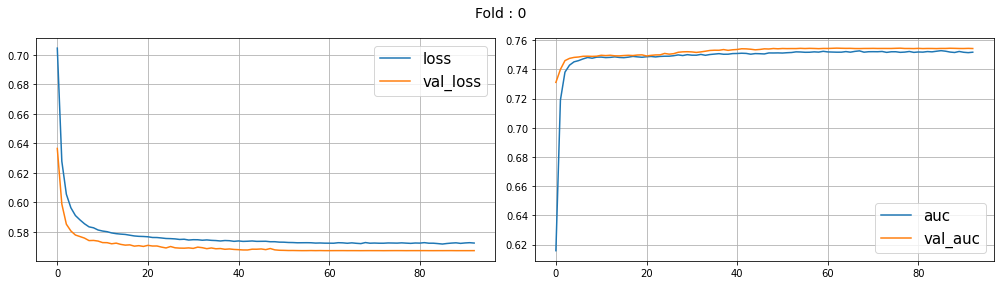

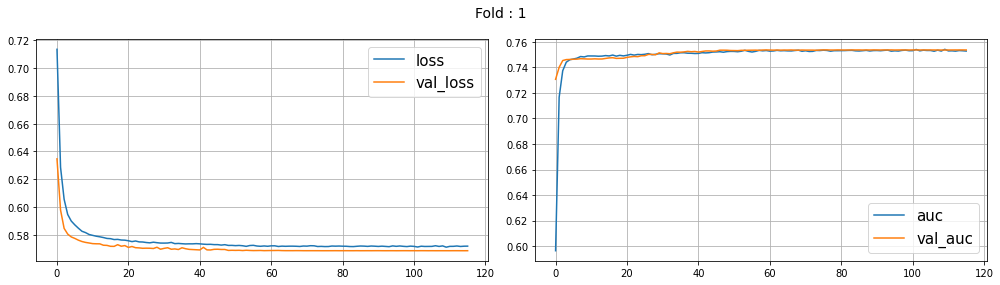

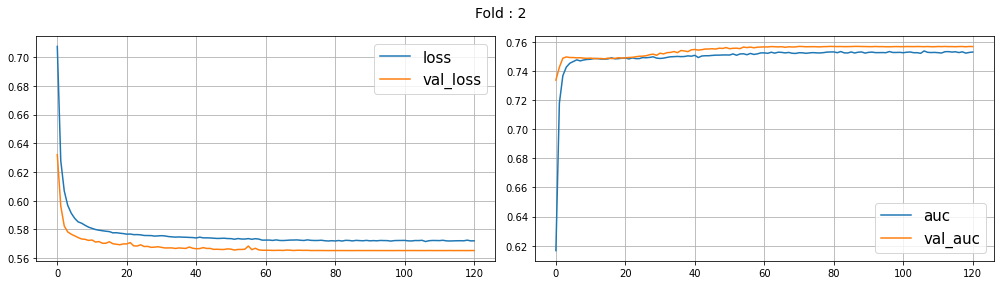

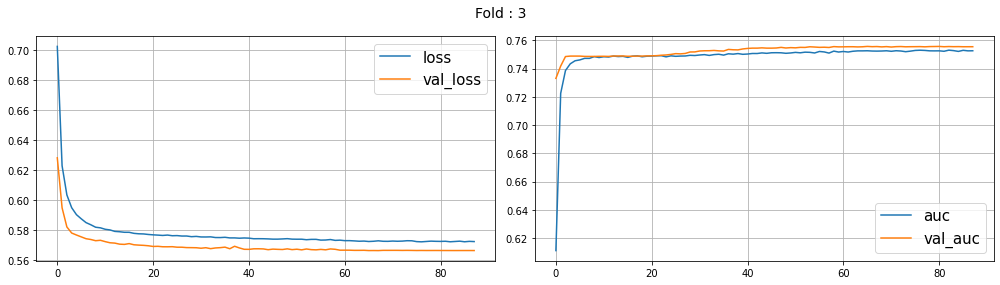

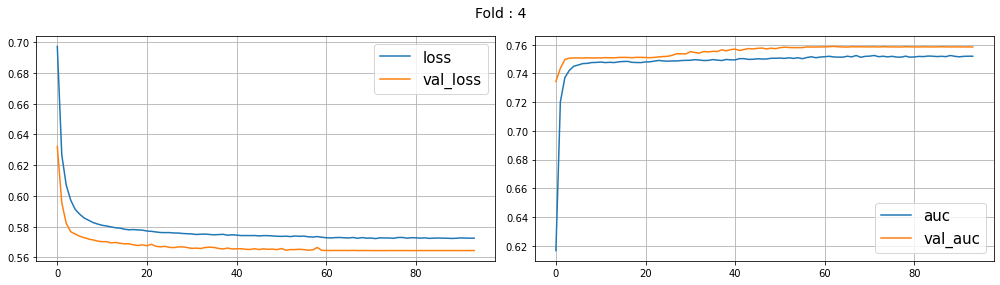

In [16]:
import matplotlib.pyplot as plt

for fold in range(f_scores['folds'].nunique()):
    history_f = f_scores[f_scores['folds'] == fold]

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(14,4))
    fig.suptitle('Fold : '+str(fold), fontsize=14)
        
    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
    plt.legend(fontsize=15)
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, ['auc', 'val_auc']],label= ['auc', 'val_auc'])
    plt.legend(fontsize=15)
    plt.grid()
    
    print("Validation Loss: {:0.4f}".format(history_f['val_loss'].min()));

# Submission

In [17]:
sub = pd.read_csv("../input/tabular-playground-series-nov-2021/sample_submission.csv")
sub[target_col] = np.mean(preds_test, axis = 0)
sub.to_csv('submission.csv', index=False)
sub.head()

,id,target
0,600000,0.734982
1,600001,0.741557
2,600002,0.743278
3,600003,0.290282
4,600004,0.708530
